In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [2]:
def display_frames_as_gif(frames):
    '''Displays a list of frames as a gif, with controls'''
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    
    anim.save('movie_cartpole.mp4')
    display(display_animation(anim, default_mode='loop'))

In [3]:
ENV = 'CartPole-v0'
NUM_DIZITIZED = 6 # 각 상태를 이산변수로 변환할 구간 수
GAMMA = 0.99 # 시간할인율
ETA = 0.5 # 학습률
MAX_STEPS = 200 # 1에피소드당 최대 단계 수
NUM_EPISODES = 1000 # 최대 에피소드 수

In [4]:
class Agent:
    '''Cart with pole'''
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
    
    def update_Q_function(self, observation, action, reward, observation_next):
        '''modify Q function'''
        self.brain.update_Q_table(observation, action, reward, observation_next)
        
    def get_action(self, observation, step):
        '''dicide action'''
        action = self.brain.decide_action(observation, step)
        return action

In [5]:
class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions
        
        # row : 상태를 구간수^4(변수의 수)가지 값 중 하나로 변환한 값
        # col : 행동의 가짓수
        self.q_table = np.random.uniform(low=0, high=1, size=(NUM_DIZITIZED**num_states, num_actions))
        
    def bins(self, clip_min, clip_max, num):
        '''convert continuous value into discrete variable'''
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        '''convert observation into discrete variable'''
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])
    
    def update_Q_table(self, observation, action, reward, observation_next):
        '''modify Q table by Q learning'''
        state = self.digitize_state(observation)
        state_next = self.digitize_state(observation_next)
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])
        
    def decide_action(self, observation, episode):
        '''epsilon greedy algorithm'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))
        
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)
        
        return action

In [6]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV)
        num_states = self.env.observation_space.shape[0]
        num_actions = self.env.action_space.n
        self.agent = Agent(num_states, num_actions)
        
    def run(self):
        complete_episodes = 0
        is_episode_final = False
        frames = []
        
        for episode in range(NUM_EPISODES):
            observation = self.env.reset()
            
            for step in range(MAX_STEPS):
                if is_episode_final is True:
                    frames.append(self.env.render(mode='rgb_array'))
                    
                action = self.agent.get_action(observation, episode)
                observation_next, _, done, _ = self.env.step(action)
                
                if done:
                    if step < 195:
                        reward = -1
                        complete_episodes = 0
                    else:
                        reward = 1
                        complete_episodes += 1        
                else:
                    reward = 0
                    
                self.agent.update_Q_function(observation, action, reward, observation_next)
                observation = observation_next
                
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(episode, step + 1))
                    break
                    
            if is_episode_final is True:
                display_frames_as_gif(frames)
                break
            
            if complete_episodes >= 10:
                print('success 10 episodes')
                is_episode_final = True

/Users/kiera/Desktop/rl_env/rl_env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


0 Episode: Finished after 16 time steps
1 Episode: Finished after 15 time steps
2 Episode: Finished after 11 time steps
3 Episode: Finished after 10 time steps
4 Episode: Finished after 85 time steps
5 Episode: Finished after 12 time steps
6 Episode: Finished after 102 time steps
7 Episode: Finished after 21 time steps
8 Episode: Finished after 20 time steps
9 Episode: Finished after 24 time steps
10 Episode: Finished after 24 time steps
11 Episode: Finished after 9 time steps
12 Episode: Finished after 22 time steps
13 Episode: Finished after 27 time steps
14 Episode: Finished after 74 time steps
15 Episode: Finished after 21 time steps
16 Episode: Finished after 11 time steps
17 Episode: Finished after 20 time steps
18 Episode: Finished after 63 time steps
19 Episode: Finished after 92 time steps
20 Episode: Finished after 55 time steps
21 Episode: Finished after 179 time steps
22 Episode: Finished after 21 time steps
23 Episode: Finished after 200 time steps
24 Episode: Finished aft

MovieWriter ffmpeg unavailable. Trying to use html instead.


123 Episode: Finished after 200 time steps


ValueError: outfile must be *.htm or *.html

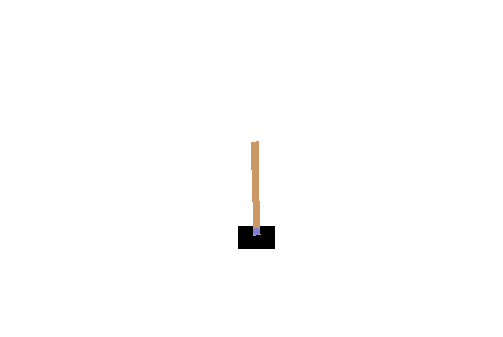

In [7]:
# main
cartpole_env = Environment()
cartpole_env.run()